In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [3]:
dev = qml.device("default.qubit",wires=8)

In [4]:
def Ue(x,i):
    #print("x inside rx",x)
    qml.RX(x,wires=i)
    
def U1(p1,p2,i,j):
    qml.CRX(p1,wires=[i,j])
    qml.CRX(p2,wires=[j,i])
    
def U2(p,c):
    for k in range(c):
        qml.CRX(p[k],wires=[k,(k+1)%c])

In [5]:
def layer(layer_weights):
    #qml.Hadamard(wires=0)
    #qml.Hadamard(wires=1)
    for wire in range(4):
        qml.RY(layer_weights[wire], wires=[wire])
    for i in range(4):
        qml.CNOT(wires=[i, (i+1)%4])
    #qml.Hadamard(wires=0)
    #qml.Hadamard(wires=1)
    #print(qml.state())

In [63]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2])

    #return x


def state_preparation(a):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.CNOT(wires=[0, 1])
    #qml.RX(a[1], wires=1)
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[1,2])
    #qml.RX(a[2], wires=2)
    qml.RY(a[2], wires=2)
    qml.CNOT(wires=[1,2])
    
    
    #qml.PauliX(wires=0)
    
    qml.CNOT(wires=[2, 3])
    #qml.RX(a[3], wires=3)
    qml.RY(a[3], wires=3)
    qml.CNOT(wires=[2, 3])
    
    
    qml.CNOT(wires=[3,0])
    #qml.RX(a[0], wires=0)
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[3,0])
    #qml.RY(a[4], wires=1)
    #qml.PauliX(wires=0)
    
    
    
    

In [52]:
@qml.qnode(dev)
def circuit_final(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)
    #
    
    return qml.expval(qml.PauliZ(0))  #np.array([qml.expval(qml.PauliZ(i)) for i in range(4)]) #qml.expval(qml.PauliZ(0))  #qml.state()

In [53]:
@qml.qnode(dev)
def circuit(p, q,k,t):
    #state_preparation(x)

    #for t in range(4):
        # Ue encoding
    #print("----------",t)
    #print("q.shape,k.shape",q.shape,k.shape)
    for n in range(4):
        #print("q[t', k[n],",q[t].shape,k[n].shape,q[t],k[n])
        Ue( q[t], n*2 )
        Ue( k[n], n*2 )
        
    #print('encoding done')
         
        # U1 construction
    for y in range(2):
        U1( p[y*2],p[y*2+1], y*2 , y*2 +1 )
            
        
        # U2 construction    
    U2(p[8:16],8)
        
    #print('first layer done')
    #
    #print('all layers done')
    return qml.expval(qml.PauliZ(0)) #np.array([qml.expval(qml.PauliZ(i)) for i in range(0,32,8)]) #qml.expval(qml.PauliZ(0))  #qml.state()
    #return np.array([qml.expval(qml.PauliZ(i)) for i in range(0,8,2)]) 

In [54]:
@qml.qnode(dev)
def circuit_compressed(p, q,k,t):
    #state_preparation(x)

    #for t in range(4):
        # Ue encoding
    #print("----------",t)
    #print("q.shape,k.shape",q.shape,k.shape)
    for n in range(4):
        #print("q[t', k[n],",q[t].shape,k[n].shape,q[t],k[n])
        Ue( q[t], n )
        Ue( k[n], n )
        
    #print('encoding done')
         
        # U1 construction
    for y in range(4-1):
        U1( p[y*2],p[y*2+1], y , y +1 )
            
        
        # U2 construction    
    U2(p[8:16],4)
        
    #print('first layer done')
    #
    #print('all layers done')
    return qml.expval(qml.PauliZ(0)) #np.array([qml.expval(qml.PauliZ(i)) for i in range(0,32,8)]) #qml.expval(qml.PauliZ(0))  #qml.state()
    #return np.array([qml.expval(qml.PauliZ(i)) for i in range(0,8,2)]) 

In [55]:
def variational_classifier(params, bias, x):
    #qml.drawer.use_style('black_white')
    #fig, ax = qml.draw_mpl(circuit)(weights,x)
    #print(weights.shape,bias.shape, x.shape)
    res=[]
    #print("_____________________________________inside variational after cost_______________shape of x")
    #print(x.shape)
    for i in range(4):
        res.append(circuit_compressed(params[i], x,x,i) + bias)
        #print(i,res)
    return circuit_final(params[4:],res)
    #return np.array(res)[0]
    

In [56]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [57]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [58]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    #print('before cost')
    predictions = [variational_classifier(weights, bias, i.T) for i in X]
    #if predictions.shape[-1]<10:
        #print("v",predictions)
    #print('after cost____square loss error')
    
    return square_loss(Y, predictions)

In [59]:
#pip install scikit-learn

# Forex - Finance Sequential analysis Dataset

In [143]:
#pip install yfinance

In [144]:
#pip install pandas numpy alpha-vantage


In [162]:
import pandas as pd
import numpy as np
from alpha_vantage.foreignexchange import ForeignExchange

# Initialize Alpha Vantage API client
api_key = '2VQY9EELOTF1JBZN'  # Replace with your Alpha Vantage API key
fx = ForeignExchange(key=api_key)

# Download historical Forex data for EUR/USD
# 'from_symbol' is the base currency, and 'to_symbol' is the quote currency
data, _ = fx.get_currency_exchange_intraday(from_symbol='EUR', to_symbol='USD', interval='15min', outputsize='full')

# Convert data to DataFrame
df = pd.DataFrame(data).T
df.columns = ['open', 'high', 'low', 'close']
df.index = pd.to_datetime(df.index)

# Step 4: Feature Selection and Preprocessing

# Select only 4 features to mimic the structure of the Iris dataset
# Here we choose open, high, low, and close prices
df = df[['open', 'high', 'low', 'close']].astype(float)

# Normalize features (e.g., using Min-Max Scaling)
df = (df - df.min()) / (df.max() - df.min())

# Generate labels for classification (e.g., if the next close price is higher or lower)
df['target'] = np.where(df['close'].shift(-1) > df['close'], 1, -1)  # 1 for upward movement, 0 for downward

# Drop NaN values caused by the shift operation
df = df.dropna()

# Display the first few rows of the preprocessed dataset
print(df.head())

# The dataset now has 4 features (open, high, low, close) and a binary target for classification


ValueError: Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints

In [217]:
import yfinance as yf
import pandas as pd
from pennylane import numpy as np

# Step 1: Download Forex Data using Yahoo Finance
# Fetch historical Forex data for EUR/USD (Euro to US Dollar)
data = yf.download('EURUSD=X', interval='1h', start='2023-01-01', end='2023-12-31')

# Step 2: Preprocess the Data
# Select only 4 features (Open, High, Low, Close)
df = data[['Open', 'High', 'Low', 'Close']]

# Step 3: Normalize the features using Min-Max Scaling
df = (df - df.min()) / (df.max() - df.min())

# Step 4: Generate target labels for classification
# Example: Predict whether the next close price is higher (1) or lower (0)
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1.0, -1.0)

# Remove any NaN values caused by the shift operation
df = df.dropna()

# Display the first few rows of the preprocessed dataset
print(df.head())

# Save the preprocessed data to a CSV file
df.to_csv('preprocessed_forex_data.csv', index=True)


[*********************100%%**********************]  1 of 1 completed


                               Open      High       Low     Close  target
Datetime                                                                 
2023-01-02 00:00:00+00:00  0.305668  0.299488  0.307122  0.315133    -1.0
2023-01-02 01:00:00+00:00  0.317054  0.300907  0.309980  0.312289    -1.0
2023-01-02 02:00:00+00:00  0.309934  0.290982  0.304264  0.309447     1.0
2023-01-02 03:00:00+00:00  0.311359  0.296652  0.309980  0.315133    -1.0
2023-01-02 04:00:00+00:00  0.314206  0.299488  0.307122  0.305187    -1.0


In [94]:
import yfinance as yf
import pandas as pd
from pennylane import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Download Stock Price Data using Yahoo Finance
# Fetch historical data for an S&P 500 company (e.g., Apple Inc.)
data = yf.download('AAPL', interval='1d', start='2022-01-01', end='2023-12-31')

# Step 2: Create Sequential Features
# Compute moving averages (e.g., 5-day and 10-day) and daily returns
data['5-day MA'] = data['Close'].rolling(window=5).mean()
data['10-day MA'] = data['Close'].rolling(window=10).mean()
data['Daily Return'] = data['Close'].pct_change()

# Drop NaN values that are a result of rolling operations
data = data.dropna()

# Step 3: Select 4 Sequential Features (Close, 5-day MA, 10-day MA, Daily Return)
df = data[['Close', '5-day MA', '10-day MA', 'Daily Return']]

# Step 4: Normalize the features using StandardScaler
scaler = StandardScaler()
df[['Close', '5-day MA', '10-day MA', 'Daily Return']] = scaler.fit_transform(df[['Close', '5-day MA', '10-day MA', 'Daily Return']])

# Step 5: Generate Target Labels for Classification
# Example: Predict whether the next day's close price is higher (1.0) or lower (0.0)
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1.0, 0.0)

# Remove NaN values caused by the shift operation
df = df.dropna()

# Print Label Distribution
label_distribution = df['target'].value_counts()
print("Label Distribution:")
print(label_distribution)

label_percentage = df['target'].value_counts(normalize=True) * 100
print("\nLabel Percentage Distribution:")
print(label_percentage)

# Save the preprocessed data to a CSV file
df.to_csv('sequential_stock_data.csv', index=True)


[*********************100%%**********************]  1 of 1 completed

Label Distribution:
target
1.0    251
0.0    241
Name: count, dtype: int64

Label Percentage Distribution:
target
1.0    51.01626
0.0    48.98374
Name: proportion, dtype: float64



C:\Users\Lokes S\AppData\Local\Temp\ipykernel_20016\3973041439.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Close', '5-day MA', '10-day MA', 'Daily Return']] = scaler.fit_transform(df[['Close', '5-day MA', '10-day MA', 'Daily Return']])
C:\Users\Lokes S\AppData\Local\Temp\ipykernel_20016\3973041439.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1.0, 0.0)


In [147]:
X = np.array(df[['Close', '5-day MA', '10-day MA', 'Daily Return']])
print(f"First X sample (original)  : {X[0]}")

KeyError: "None of [Index(['Close', '5-day MA', '10-day MA', 'Daily Return'], dtype='object')] are in the [columns]"

In [96]:
#data = np.loadtxt("iris.txt")
X = np.array(df[['Close', '5-day MA', '10-day MA', 'Daily Return']])
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
#padding = np.ones((len(X), 2)) * 0.1
#X_pad = np.c_[X, padding]
#print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X**2, -1))
X_norm = (X.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = np.array(df['target'])

First X sample (original)  : [0.54039129 0.58416326 0.67468323 0.25709526]
First X sample (normalized): [0.5029203  0.5436571  0.62790037 0.23926815]
First features sample      : [ 1.4736599  -0.36407354  0.36407354 -0.82430236]


In [60]:
import yfinance as yf
import pandas as pd
from pennylane import numpy as np

# Step 1: Download Historical Data
# Choose a stock or financial asset (e.g., 'AAPL' for Apple)
ticker = 'AAPL'
data = yf.download(ticker, start='2023-01-01', end='2024-01-01', progress=False)

# Step 2: Prepare the Sequential Dataset with 12 Features (Daily Closing Prices)
# Ensure there are enough rows to form sequences
if len(data) < 13:
    raise ValueError("Not enough data to create a sequence with 12 days and a label.")

# Extract the 'Close' column (daily closing prices)
closing_prices = data['Close'].tolist()

# Create a sequential dataset of 12 features
# This will create sequences of 12 consecutive days
sequences = []
labels = []
for i in range(len(closing_prices) - 5):
    sequence = closing_prices[i:i+4]  # Days 1 to 12
    day_13 = closing_prices[i+4]      # Day 13
    
    # Determine the label: 1 if Day 13 is higher than Day 12, else 0
    label = 1.0 if day_13 > sequence[-1] else -1.0
    
    sequences.append(sequence)
    labels.append(label)

# Convert to DataFrame for easy manipulation
df = pd.DataFrame(sequences, columns=[f"Day {i+1}" for i in range(4)])
df['target'] = labels

# Step 3: Normalize the Data
# Normalize each sequence to the range [0, 1] or [0, 2π] for quantum encoding
# Here we normalize to [0, 2π]
#df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: 2 * np.pi * (x - x.min()) / (x.max() - x.min()), axis=1)

# Display the normalized dataset with labels
print(df.shape)

# Optionally, save the dataset to a CSV file
df.to_csv('normalized_sequential_data_with_labels.csv', index=False)

# Print Label Distribution
label_distribution = df['target'].value_counts()
print("Label Distribution:")
print(label_distribution)

label_percentage = df['target'].value_counts(normalize=True) * 100
print("\nLabel Percentage Distribution:")
print(label_percentage)



(245, 5)
Label Distribution:
target
 1.0    137
-1.0    108
Name: count, dtype: int64

Label Percentage Distribution:
target
 1.0    55.918367
-1.0    44.081633
Name: proportion, dtype: float64


In [61]:
feat=[]
for  i in df.columns:
    if i != 'target':
        feat.append(i)
feat

['Day 1', 'Day 2', 'Day 3', 'Day 4']

In [65]:
#data = np.loadtxt("iris.txt")
X = np.array(df[feat])
print(f"First X sample (original)  : {X[3]}")

# pad the vectors to size 2^2=4 with constant values
#padding = np.ones((len(X), 2)) * 0.1
#X_pad = np.c_[X, padding]
#print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)
#normalization = np.sqrt(np.sum(X**2, -1))
#X_norm = (X.T / normalization).T
print(f"First X sample (normalized): {X_norm[3]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
#features = 2*np.pi*X_norm
print(f"First features sample      : {features[:]}")

Y = np.array(df['target'])

First X sample (original)  : [129.61999512 130.1499939  130.72999573 133.49000549]
First X sample (normalized): [-2.46896156 -2.48493747 -2.49720019 -2.38191224]
First features sample      : [[ 1.57372841 -0.74477246  0.74477246 -0.78072443]
 [ 1.51424222 -0.78932437  0.78932437 -0.80895604]
 [ 1.53662823 -0.78869601  0.78869601 -0.74352881]
 [ 1.55585914 -0.76177368  0.76177368 -0.78862307]
 [ 1.53560869 -0.79680504  0.79680504 -0.78798617]
 [ 1.55978541 -0.7784207   0.7784207  -0.76069412]
 [ 1.56054809 -0.78022204  0.78022204 -0.79620835]
 [ 1.57153107 -0.80578684  0.80578684 -0.77756   ]
 [ 1.61393177 -0.79515928  0.79515928 -0.77938208]
 [ 1.58371326 -0.76023055  0.76023055 -0.80533033]
 [ 1.49125258 -0.74782953  0.74782953 -0.79454218]
 [ 1.45498876 -0.77383847  0.77383847 -0.75907759]
 [ 1.52798897 -0.80773143  0.80773143 -0.74642757]
 [ 1.57832026 -0.76179962  0.76179962 -0.77284965]
 [ 1.51989223 -0.76190824  0.76190824 -0.80736025]
 [ 1.56355588 -0.84872076  0.84872076 -0.760

# Sentimental Analysis Dataset

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
import numpy as np

# Prepare the tokenizer
sentences = filtered_data['sentence'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)
max_len = 4  # maximum length of 4 words
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Embedding layer
embedding_dim = 50
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_len)

# Get embeddings
embeddings = embedding_layer(padded_sequences).numpy()

# Convert labels to numpy arrays
labels = filtered_data['label'].values


In [314]:
pip install transformers

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ------ --------------------------------- 1.6/9.5 MB 10.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.6/9.5 MB 6.6 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.5 MB 6.8 MB/s eta 0:00:01
   --------------------- ------------------ 5.0/9.5 MB 6.3 MB/s eta 0:00:01
   ----------------------- ---------------- 5.5/9.5 MB 5.6 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.5 MB 5.1 MB/s eta 0:00:01
   ----------------------------- ---------- 7.1/9.5 MB 4.8 MB/s eta 0:00:01
   --------------------------------- ------ 7.9/9.5 MB 4.7 MB/s eta 0:00:01
   ------------------------------------- -- 8.9/9.5 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.5 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------ ---

In [323]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
from transformers import BertTokenizer, BertModel
import torch

def generate_bert_embeddings(texts):
    """
    Generates BERT embeddings for a list of texts.

    Parameters:
    texts (list of str): List of sentences or documents.

    Returns:
    embeddings (list of torch.Tensor): List of embeddings for each sentence.
    """
    
    # Load pre-trained BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Initialize an empty list to store embeddings
    embeddings = []

    # Loop through each text
    for text in texts:
        # Tokenize the text and obtain input IDs and attention masks
        inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # Get the output from BERT
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        # Obtain the embeddings from the last hidden state
        last_hidden_state = outputs.last_hidden_state

        # Aggregate word embeddings to get a sentence-level embedding (mean pooling)
        sentence_embedding = torch.mean(last_hidden_state, dim=1)

        # Append the sentence embedding to the list
        embeddings.append(sentence_embedding)

    return embeddings

# Example usage
texts = [
    "I love machine learning and deep learning.",
    "Deep learning and machine learning are fascinating fields!",
    "Natural language processing is a key area of AI.",
    "AI and machine learning can transform the world."
]

# Generate BERT embeddings for the texts
embeddings = generate_bert_embeddings(texts)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

e:\Anaconda\envs\quantum\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lokes S\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

e:\Anaconda\envs\quantum\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding for sentence 1: tensor([[ 1.2227e-01, -2.8492e-01,  1.9761e-01,  2.7807e-01,  3.1148e-01,
         -6.9994e-02, -3.1194e-02,  5.3126e-01,  6.0480e-02, -5.9650e-01,
         -6.4283e-03,  6.9417e-02,  2.6264e-01,  3.2859e-01,  1.2673e-01,
         -6.1190e-02,  2.4824e-01,  1.9888e-01,  2.3093e-01,  3.2356e-01,
         -1.6090e-01,  4.0023e-02,  5.5935e-02,  1.1751e-01,  3.4442e-01,
          2.4907e-01, -4.7345e-01, -1.2501e-02, -9.5864e-02,  1.0258e-01,
          1.0576e-01, -2.8447e-01,  3.7431e-01,  3.2660e-01, -2.8057e-01,
         -3.4362e-01, -5.7147e-01,  1.2335e-01, -3.2136e-01,  2.7031e-02,
          6.2436e-02, -5.0364e-03, -1.5062e-01, -5.5853e-01, -5.6550e-02,
         -1.1906e-01, -1.4752e-01, -1.6273e-02,  6.9876e-02, -2.7156e-01,
         -3.6538e-01,  2.7272e-01, -1.0510e-01,  2.6691e-01, -1.7148e-01,
         -2.5290e-02,  1.7463e-01, -3.2258e-01, -4.1986e-01, -5.7916e-02,
          5.1427e-01, -6.6664e-02,  3.9106e-02,  1.3768e-01,  5.1430e-02,
         -7.

In [4]:
for i, embedding in enumerate(embeddings):
    print(f"Embedding for sentence {i+1}: {len(embedding[0])}")

Embedding for sentence 1: 768
Embedding for sentence 2: 768
Embedding for sentence 3: 768
Embedding for sentence 4: 768


In [2]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


In [319]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import sequence

vocab_size = 1000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

class_names = ["Negative", "Positive"]

In [320]:
x_train[:5]

array([list([1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]),
       list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 715, 8, 118, 2, 14, 394, 20, 13, 119, 954, 189,

# WIne Classification

In [252]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", 
           "BMI", "DiabetesPedigreeFunction", "Age", "Class"]
df = pd.read_csv(url, header=None, names=columns)

df = df.astype(float)

# Step 2: Select four features and the target
selected_features = ["Pregnancies", "Glucose", "BloodPressure", "BMI"]
X = df[selected_features]
Y = np.array(df["Class"].apply(lambda x: -1.0 if x == 0 else 1.0))
#Y = np.array(df["Class"])

X = X[:700]
Y = Y[:700]

X.shape,Y.shape
# Your data is now ready for modeling


((700, 4), (700,))

In [253]:
X = np.array(X)

In [254]:
#normalization = np.sqrt(np.sum(X**2, -1))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
#X_norm = (X.T / normalization).T
print(f"First X sample (original)  : {X[0]}")
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
#features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
features = 2*np.pi*X_norm
print(f"First features sample      : {features[0]}")

#Y = data[:, -1]

First X sample (original)  : [  6.  148.   72.   33.6]
First X sample (normalized): [0.35294118 0.74371859 0.59016393 0.50074516]
First features sample      : [2.21759481 4.67292174 3.70810936 3.14627461]


In [255]:
Y.shape

(700,)

# Iris Dataset

In [230]:
data = np.loadtxt("iris.txt")
data[0]

tensor([ 0.4 ,  0.75,  0.2 ,  0.05, -1.  ], requires_grad=True)

In [235]:
from pennylane import numpy as np
data = np.loadtxt("iris.txt")
X = data[:, 0:4]
print(X.shape,type(X))
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
#padding = np.ones((len(X), 2)) * 0.1
#X_pad = np.c_[X, padding]
#print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
#################################################
#normalization = np.sqrt(np.sum(X**2, -1))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
#X_norm = (X.T / normalization).T
print(f"First X sample (original)  : {X[0]}")
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
#features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
features = 2*np.pi*X_norm
print(f"First features sample      : {features[0]}")

Y = data[:, -1]


##########################################
#normalization = np.sqrt(np.sum(X**2, -1))
#X_norm = (X.T / normalization).T
#print(f"First X sample (normalized): {X_norm[0]}")
#
## the angles for state preparation are the features
#features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
#print(f"First features sample      : {features[0]}")
#
#Y = data[:, -1]

(100, 4) <class 'pennylane.numpy.tensor.tensor'>
First X sample (original)  : [0.4  0.75 0.2  0.05]
First X sample (original)  : [0.4  0.75 0.2  0.05]
First X sample (normalized): [0.2962963  0.625      0.09756098 0.05882353]
First features sample      : [1.86168454 3.92699082 0.61299369 0.36959914]


In [236]:
Y.shape

(100,)

# Traning

In [33]:
len(Y),len(index)

(245, 246)

In [34]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

print(feats_train[:5],feats_val[:5])
print(Y_train[:12])
print(X_train.shape,X_val.shape)

[[3.11125253 3.12246286 3.16513478 3.16712374]
 [3.15075275 3.15314007 3.14454548 3.11780629]
 [3.16937076 3.15084175 3.12002363 3.12588474]
 [3.14455212 3.17066948 3.13169149 3.11922636]
 [3.16806573 3.19144712 3.11677227 3.08904079]] [[3.14112907 3.09638048 3.10916589 3.2182668 ]
 [3.1416119  3.13740112 3.15958804 3.12768444]
 [3.14564415 3.11700795 3.13873183 3.16480085]
 [3.088499   3.14771255 3.15140293 3.17807439]
 [3.10156107 3.12422927 3.14671739 3.19313289]]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1.]
(183, 4) (62, 4)


In [35]:
Y_train[11]

tensor(-1., requires_grad=True)

In [36]:
num_qubits = 4
num_layers = 4
from pennylane import numpy as np

weights_init = 0.01 * np.random.randn(4 + num_layers, 16, requires_grad=True) #+ 0.01 * np.random.randn(num_layers, num_qubits, requires_grad=True)
#weight_final = 0.01 * np.random.randn(num_layers, num_qubits,3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

weights_init.shape

(8, 16)

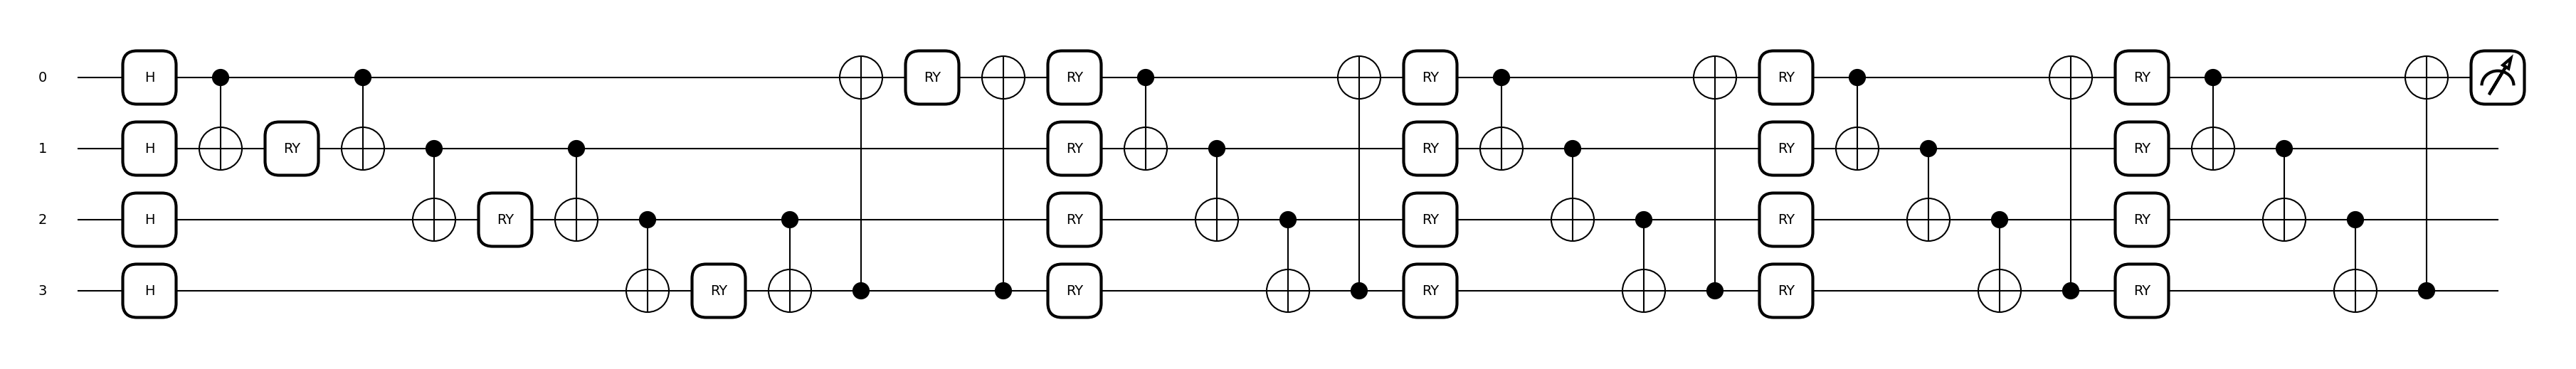

In [37]:
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(circuit_final)(weights_init[4:],feats_train)

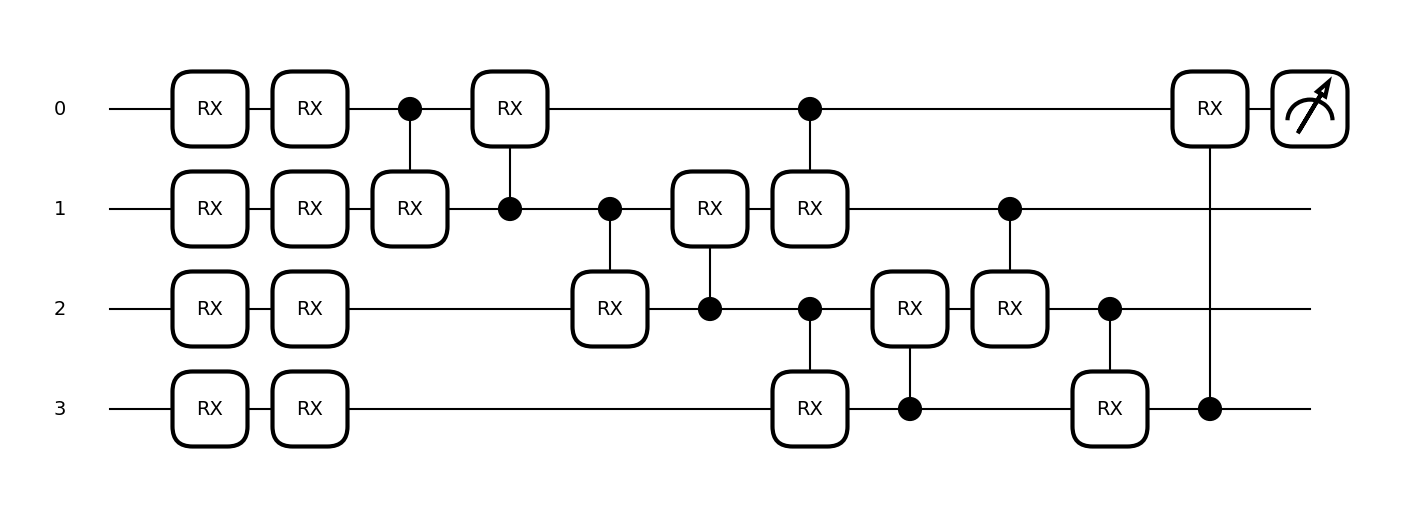

In [38]:
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(circuit_compressed)(weights_init[0],feats_train[0],feats_train[0],0)

In [39]:
#pip install --upgrade tensorflow

In [40]:
batch_index = np.random.randint(0, 1000, (5,))
batch_index

tensor([248, 365, 947, 201, 437], requires_grad=True)

In [48]:
opt = NesterovMomentumOptimizer(0.1)
#import tensorflow as tf
#opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init

acc_train_list,acc_val_list,cost_list = [],[],[]
for it in range(50):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    #print('before quantum')
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)
    #print('crossed quantum')
    #if it==0:
    #    qml.drawer.use_style('black_white')
    #    fig, ax = qml.draw_mpl(circuit)(weights,feats_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.array([np.sign(variational_classifier(weights, bias, i.T)) for i in feats_train])
    predictions_val = np.array([np.sign(variational_classifier(weights, bias, j.T)) for j in feats_val])
    print("prediction Train",predictions_train[:10])
    print("Y_train",Y_train[:10])
    #print("prediction val",predictions_val)
    #print("y_val",Y_val)
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    #_cost = cost(weights, bias, features, Y)
    #print("acc_train:acc_val",acc_train,acc_val)
    #cost_list.append(_cost)
    if (it + 1) % 1 == 0:
        
        #print(_cost,acc_train,acc_val)
        print(
            #f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

prediction Train [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Y_train [ 1.  1. -1.  1. -1.  1.  1.  1.  1.  1.]
Acc train: 0.4076087 | Acc validation: 0.5483871
prediction Train [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Y_train [ 1.  1. -1.  1. -1.  1.  1.  1.  1.  1.]
Acc train: 0.4076087 | Acc validation: 0.5483871


: 

In [47]:
feats_train.shape, Y_train.shape, feats_val.shape, Y_val.shape
Y_train = Y_train[:180]
feats_val = feats_val[:60]
Y_val = Y_val[:60]
num_train=180

In [48]:
# Number of epochs
#import torch
#import torch.optim as optim
opt = NesterovMomentumOptimizer(0.1)
#optimizer = optim.Adam(lr=0.001)
epochs = 50
batch_size = 5



# train the variational classifier
weights = weights_init
bias = bias_init

# Initialize lists to store metrics
acc_train_list, acc_val_list, cost_list = [], [], []

# Start the training loop
for epoch in range(epochs):
    # Shuffle the training data at the beginning of each epoch
    permutation = np.random.permutation(num_train)
    feats_train_shuffled = feats_train[permutation]
    Y_train_shuffled = Y_train[permutation]
    
    # Mini-batch training
    for i in range(0, num_train, batch_size):
        # Create mini-batch
        feats_train_batch = feats_train_shuffled[i:i + batch_size]
        Y_train_batch = Y_train_shuffled[i:i + batch_size]

        # Print shapes for debugging
        #print("weights shape:", weights.shape)
        #print("bias shape:", bias.shape)
        #print("feats_train_batch shape:", feats_train_batch.shape)
        #print("Y_train_batch shape:", Y_train_batch.shape)
        
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)
        #if i %100==0:
            #print("inside batch",i,weights[0])

    # Compute predictions on the entire train and validation sets
    predictions_train = np.array([np.sign(variational_classifier(weights, bias, i.T)) for i in feats_train])
    predictions_val = np.array([np.sign(variational_classifier(weights, bias, j.T)) for j in feats_val])
    
    # Compute accuracy on the entire train and validation sets
    print(predictions_train[:10])
    print(Y_train[:10])
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    
    # Store the accuracies
    acc_train_list.append(acc_train)
    acc_val_list.append(acc_val)
    
    # Print the accuracy for each epoch
    print(f"Epoch: {epoch + 1:5d} | Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}")

# The data is now used more effectively, which should help with model performance


[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     1 | Acc train: 0.3888889 | Acc validation: 0.5833333
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     2 | Acc train: 0.6111111 | Acc validation: 0.4166667
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     3 | Acc train: 0.6111111 | Acc validation: 0.4166667
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     4 | Acc train: 0.6111111 | Acc validation: 0.4166667
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     5 | Acc train: 0.6111111 | Acc validation: 0.4166667
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     6 | Acc train: 0.6111111 | Acc validation: 0.4166667
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-1.  1. -1.  1.  1. -1. -1.  1. -1. -1.]
Epoch:     7 | Acc train: 0.6111111 | Acc validation: 0.4166667
[1. 1. 1. 1. 1. 1. 1. 1.

In [49]:
l=[0]
l+=acc_train_list
l2=[0]
l2+=acc_val_list

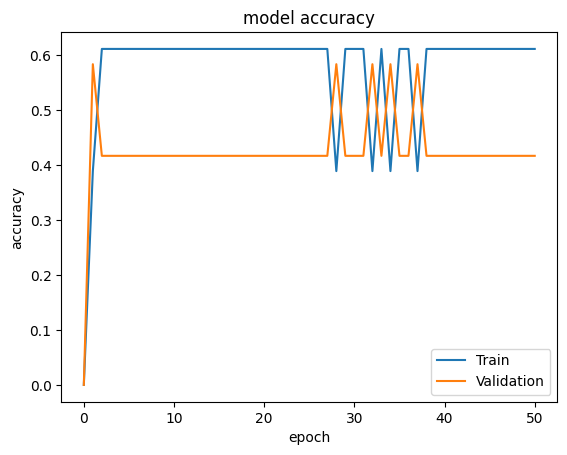

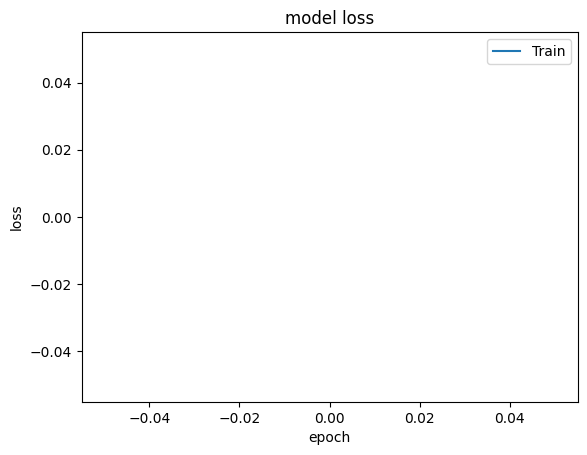

In [50]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(l[:1000])
plt.plot(l2[:1000])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()
# summarize history for loss
plt.plot(cost_list)
#plt.plot(acc_val_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Classical approach

In [63]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()

# Create a DataFrame
iris_data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_data['label'] = iris.target

# Filter the dataset to include only two classes (0 and 1)
binary_iris_data = iris_data[iris_data['label'] != 2]

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and labels
X = binary_iris_data.drop('label', axis=1)
y = binary_iris_data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for the self-attention model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [69]:
X_train[:5]

array([[[ 0.34989908],
        [-0.5881428 ],
        [ 1.13555602],
        [ 0.89744481]],

       [[ 0.19609729],
        [-0.16040258],
        [ 0.8521099 ],
        [ 0.89744481]],

       [[-0.72671348],
        [ 0.69507785],
        [-0.91942835],
        [-0.73427302]],

       [[-1.64952424],
        [ 0.26733764],
        [-1.13201294],
        [-1.09687699]],

       [[ 0.19609729],
        [-1.22975312],
        [ 0.71038684],
        [ 0.53484084]]])

In [72]:
X_train.shape,y_train.shape

((80, 4, 1), (80,))

In [97]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

print(feats_train[:5],feats_val[:5])
print(Y_train.shape,Y_val.shape)
print(X_train.shape,X_val.shape)

[[ 1.34605712 -0.55579091  0.55579091 -0.75533671]
 [ 2.12981297 -1.10460876  1.10460876 -0.68770411]
 [ 1.94112323 -0.19385953  0.19385953 -1.3821433 ]
 [ 2.25264433 -1.44179303  1.44179303 -0.49010457]
 [ 1.04037899 -0.63951726  0.63951726 -0.89630864]] [[ 1.18418067 -0.07532278  0.07532278 -0.79481657]
 [ 1.85560324 -0.91316312  0.91316312 -0.6818121 ]
 [ 1.68947233 -0.75993523  0.75993523 -0.81302326]
 [ 1.29341404 -0.50077866  0.50077866 -0.85156175]
 [ 2.41273018 -1.20242933  1.20242933 -0.36486604]]
(369,) (123,)
(369, 4) (123, 4)


In [98]:
X_train = X_train.reshape(369,4,1)
X_train.shape

(369, 4, 1)

In [99]:
X_val = X_val.reshape(123,4,1)
X_val.shape

(123, 4, 1)

In [100]:
y_train = Y_train
y_test = Y_val
X_test = X_val

In [101]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((369, 4, 1), (123, 4, 1), (369,), (123,))

# Trial Datasets

In [111]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Download historical data for Bitcoin
data = yf.download('BTC-USD', interval='1d', start='2022-01-01', end='2023-12-31')

# Compute features
data['5-day MA'] = data['Close'].rolling(window=5).mean()
data['10-day MA'] = data['Close'].rolling(window=10).mean()
data['Daily Return'] = data['Close'].pct_change()

# Drop NaN values
data = data.dropna()

# Select features
df = data[['Close', '5-day MA', '10-day MA', 'Daily Return']]

# Normalize features
scaler = StandardScaler()
df[['Close', '5-day MA', '10-day MA', 'Daily Return']] = scaler.fit_transform(df[['Close', '5-day MA', '10-day MA', 'Daily Return']])

# Generate target labels
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1.0, 0.0)
df = df.dropna()

# Save the preprocessed data
df.to_csv('sequential_crypto_data.csv', index=True)


[*********************100%%**********************]  1 of 1 completed


C:\Users\Lokes S\AppData\Local\Temp\ipykernel_20016\2181504220.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Close', '5-day MA', '10-day MA', 'Daily Return']] = scaler.fit_transform(df[['Close', '5-day MA', '10-day MA', 'Daily Return']])
C:\Users\Lokes S\AppData\Local\Temp\ipykernel_20016\2181504220.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1.0, 0.0)


In [121]:
pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29422 sha256=f7896409abc31f2342744c0f07dae594015e3499635ff2be62fafbf945e8d489
  Stored in directory: c:\users\lokes s\appdata\local\pip\cache\wheels\a1\d7\29\7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [131]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta  # Technical Analysis library
from sklearn.preprocessing import StandardScaler

# Step 1: Download Stock Price Data using Yahoo Finance
data = yf.download('AAPL', interval='1d', start='2022-01-01', end='2023-12-31')

# Step 2: Create Sequential Features
data['5-day MA'] = data['Close'].rolling(window=5).mean()
data['10-day MA'] = data['Close'].rolling(window=10).mean()
data['Daily Return'] = data['Close'].pct_change()

# Add technical indicators
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
macd = ta.trend.MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD Signal'] = macd.macd_signal()
bollinger = ta.volatility.BollingerBands(data['Close'])
data['Bollinger High'] = bollinger.bollinger_hband()
data['Bollinger Low'] = bollinger.bollinger_lband()

# Drop NaN values resulting from rolling operations
data = data.dropna()

# Step 3: Select 8 Sequential Features
df = data[['Close', '5-day MA', '10-day MA', 'Daily Return', 'RSI', 'MACD', 'Bollinger High', 'Bollinger Low']]

# Step 4: Normalize the features
scaler = StandardScaler()
df[['Close', '5-day MA', '10-day MA', 'Daily Return', 'RSI', 'MACD', 'Bollinger High', 'Bollinger Low']] = scaler.fit_transform(df[['Close', '5-day MA', '10-day MA', 'Daily Return', 'RSI', 'MACD', 'Bollinger High', 'Bollinger Low']])

# Step 5: Generate Target Labels for Classification
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1.0, 0.0)
df = df.dropna()

# Print Label Distribution
label_distribution = df['target'].value_counts()
print("Label Distribution:")
print(label_distribution)

label_percentage = df['target'].value_counts(normalize=True) * 100
print("\nLabel Percentage Distribution:")
print(label_percentage)

# Save the preprocessed data to a CSV file
df.to_csv('eight_feature_stock_data.csv', index=True)


[*********************100%%**********************]  1 of 1 completed

Label Distribution:
target
1.0    244
0.0    224
Name: count, dtype: int64

Label Percentage Distribution:
target
1.0    52.136752
0.0    47.863248
Name: proportion, dtype: float64



C:\Users\Lokes S\AppData\Local\Temp\ipykernel_20016\1850231727.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Close', '5-day MA', '10-day MA', 'Daily Return', 'RSI', 'MACD', 'Bollinger High', 'Bollinger Low']] = scaler.fit_transform(df[['Close', '5-day MA', '10-day MA', 'Daily Return', 'RSI', 'MACD', 'Bollinger High', 'Bollinger Low']])
C:\Users\Lokes S\AppData\Local\Temp\ipykernel_20016\1850231727.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where(df['Close'].shift(-1)

In [140]:
import yfinance as yf
import pandas as pd
import numpy as np

# Step 1: Download Historical Data
# Choose a stock or financial asset (e.g., 'AAPL' for Apple)
ticker = 'AAPL'
data = yf.download(ticker, start='2023-01-01', end='2024-01-01', progress=False)

# Step 2: Prepare the Sequential Dataset with 12 Features (Daily Closing Prices)
# Ensure there are enough rows to form sequences
if len(data) < 13:
    raise ValueError("Not enough data to create a sequence with 12 days and a label.")

# Extract the 'Close' column (daily closing prices)
closing_prices = data['Close'].tolist()

# Create a sequential dataset of 12 features
# This will create sequences of 12 consecutive days
sequences = []
labels = []
for i in range(len(closing_prices) - 12):
    sequence = closing_prices[i:i+12]  # Days 1 to 12
    day_13 = closing_prices[i+12]      # Day 13
    
    # Determine the label: 1 if Day 13 is higher than Day 12, else 0
    label = 1 if day_13 > sequence[-1] else 0
    
    sequences.append(sequence)
    labels.append(label)

# Convert to DataFrame for easy manipulation
df = pd.DataFrame(sequences, columns=[f"Day {i+1}" for i in range(12)])
df['target'] = labels

# Step 3: Normalize the Data
# Normalize each sequence to the range [0, 1] or [0, 2π] for quantum encoding
# Here we normalize to [0, 2π]
df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: 2 * np.pi * (x - x.min()) / (x.max() - x.min()), axis=1)

# Display the normalized dataset with labels
print(df.head())

# Optionally, save the dataset to a CSV file
df.to_csv('normalized_sequential_data_with_labels.csv', index=False)

# Print Label Distribution
label_distribution = df['target'].value_counts()
print("Label Distribution:")
print(label_distribution)

label_percentage = df['target'].value_counts(normalize=True) * 100
print("\nLabel Percentage Distribution:")
print(label_percentage)



      Day 1     Day 2     Day 3     Day 4     Day 5     Day 6     Day 7  \
0  0.028771  0.771015  0.000000  2.646761  2.951713  3.285436  4.873499   
1  0.655214  0.000000  2.249233  2.508383  2.791983  4.141529  4.102411   
2  0.000000  1.796310  2.003276  2.229768  3.307559  3.276318  3.803493   
3  0.000000  0.257946  0.540228  1.883500  1.844564  2.501593  3.075892   
4  0.000000  0.294367  1.695146  1.654543  2.339699  2.938585  2.568093   

      Day 8     Day 9    Day 10    Day 11    Day 12  target  
0  4.827467  5.604229  6.283185  5.863158  5.897680       1  
1  4.762507  5.339489  4.982547  5.011884  6.283185       1  
2  4.264289  3.979223  4.002653  5.017955  6.283185       1  
3  2.720610  2.749810  4.015202  5.592085  6.283185       0  
4  2.598543  3.918108  5.562498  6.283185  5.943143       1  
Label Distribution:
target
1    131
0    107
Name: count, dtype: int64

Label Percentage Distribution:
target
1    55.042017
0    44.957983
Name: proportion, dtype: float64


In [141]:
df.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,target
0,0.028771,0.771015,0.000000,2.646761,2.951713,3.285436,4.873499,4.827467,5.604229,6.283185,5.863158,5.897680,1
1,0.655214,0.000000,2.249233,2.508383,2.791983,4.141529,4.102411,4.762507,5.339489,4.982547,5.011884,6.283185,1
2,0.000000,1.796310,2.003276,2.229768,3.307559,3.276318,3.803493,4.264289,3.979223,4.002653,5.017955,6.283185,1
3,0.000000,0.257946,0.540228,1.883500,1.844564,2.501593,3.075892,2.720610,2.749810,4.015202,5.592085,6.283185,0
4,0.000000,0.294367,1.695146,1.654543,2.339699,2.938585,2.568093,2.598543,3.918108,5.562498,6.283185,5.943143,1


In [142]:
#data = np.loadtxt("iris.txt")
X = np.array(df)
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
#padding = np.ones((len(X), 2)) * 0.1
#X_pad = np.c_[X, padding]
#print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
#normalization = np.sqrt(np.sum(X**2, -1))
#X_norm = (X.T / normalization).T
#print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
#features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
#print(f"First features sample      : {features[0]}")

Y = np.array(df['target'])

First X sample (original)  : [0.0287709  0.77101545 0.         2.64676076 2.95171303 3.2854362
 4.8734988  4.82746711 5.60422884 6.28318531 5.8631582  5.89767977
 1.        ]


In [143]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
#feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
#feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

#print(feats_train[:5],feats_val[:5])
print(Y_train.shape,Y_val.shape)
print(X_train.shape,X_val.shape)

(178,) (60,)
(178, 13) (60, 13)


In [303]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", 
           "BMI", "DiabetesPedigreeFunction", "Age", "Class"]
df = pd.read_csv(url, header=None, names=columns)

df = df.astype(float)

# Step 2: Select four features and the target
selected_features = ["Pregnancies", "Glucose", "BloodPressure", "BMI"]
X = np.array(df[selected_features])
Y = np.array(df["Class"].apply(lambda x: 0 if x == 0 else 1))
#Y = np.array(df["Class"])

X = X[:700]
Y = Y[:700]

X.shape,Y.shape
# Your data is now ready for modeling


((700, 4), (700,))

In [304]:
#normalization = np.sqrt(np.sum(X**2, -1))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
#X_norm = (X.T / normalization).T
#print(f"First X sample (original)  : {X[0]}")
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
#features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
#features = 2*np.pi*X_norm
print(f"First features sample      : {features[0]}")

#Y = data[:, -1]

First X sample (normalized): [0.35294118 0.74371859 0.59016393 0.50074516]
First features sample      : [2.21759481 4.67292174 3.70810936 3.14627461]


In [305]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
#feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
#feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

#print(feats_train[:5],feats_val[:5])
print(Y_train.shape,Y_val.shape)
print(X_train.shape,X_val.shape)

(525,) (175,)
(525, 4) (175, 4)


# Models

In [306]:
(X_train.shape,1)

((525, 4), 1)

In [301]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
y_train = Y_train
y_test = Y_val
X_test = X_val


e:\Anaconda\envs\quantum\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200, Train Accuracy: 0.6610, Test Accuracy: 0.6400
Epoch 2/200, Train Accuracy: 0.6819, Test Accuracy: 0.6457
Epoch 3/200, Train Accuracy: 0.7105, Test Accuracy: 0.6571
Epoch 4/200, Train Accuracy: 0.7010, Test Accuracy: 0.6743
Epoch 5/200, Train Accuracy: 0.7029, Test Accuracy: 0.6629
Epoch 6/200, Train Accuracy: 0.7467, Test Accuracy: 0.6743
Epoch 7/200, Train Accuracy: 0.7429, Test Accuracy: 0.6800
Epoch 8/200, Train Accuracy: 0.7505, Test Accuracy: 0.6629
Epoch 9/200, Train Accuracy: 0.6686, Test Accuracy: 0.6400
Epoch 10/200, Train Accuracy: 0.7695, Test Accuracy: 0.6857
Epoch 11/200, Train Accuracy: 0.7581, Test Accuracy: 0.6914
Epoch 12/200, Train Accuracy: 0.6952, Test Accuracy: 0.6343
Epoch 13/200, Train Accuracy: 0.7029, Test Accuracy: 0.6571
Epoch 14/200, Train Accuracy: 0.7181, Test Accuracy: 0.6686
Epoch 15/200, Train Accuracy: 0.7733, Test Accuracy: 0.6914
Epoch 16/200, Train Accuracy: 0.7829, Test Accuracy: 0.6743
Epoch 17/200, Train Accuracy: 0.7848, Test Accura

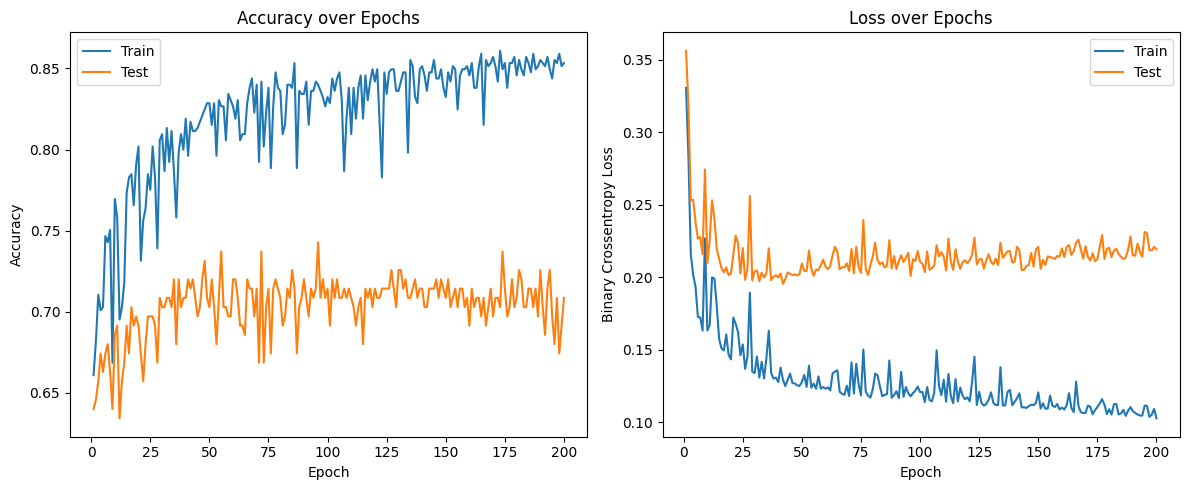

In [302]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss


# Initialize the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

# Lists to store accuracy and loss values
train_acc_history = []
test_acc_history = []
train_loss_history = []
test_loss_history = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    # Train the model for one epoch
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate on training and test data
    #y_pred = model.predict(X_test)
    #print(y_pred,y_test)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    # Append accuracy and loss to history
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    
    # Print accuracy after each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train')
plt.plot(range(1, num_epochs + 1), test_acc_history, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train')
plt.plot(range(1, num_epochs + 1), test_loss_history, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()

# Create a DataFrame
iris_data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_data['label'] = iris.target

# Filter the dataset to include only two classes (0 and 1)
binary_iris_data = iris_data[iris_data['label'] != 2]


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and labels
X = binary_iris_data.drop('label', axis=1)
y = binary_iris_data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for the self-attention model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape based on the number of features (4 in the Iris dataset)
input_layer = Input(shape=(X_train.shape[1], 1))

# Multi-head self-attention layer
attention_output = MultiHeadAttention(num_heads=2, key_dim=2)(input_layer, input_layer)

# Flatten or reshape to prepare for dense layers
flatten_layer = Flatten()(attention_output)

# Additional dense layers for better representation
dense_layer1 = Dense(32, activation='relu')(flatten_layer)
dense_layer2 = Dense(16, activation='relu')(dense_layer1)
dropout_layer = Dropout(0.5)(dense_layer2)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with reduced learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with more epochs
history = model.fit(feats_train, Y_train, epochs=50, validation_data=(feats_val, Y_val))


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 4, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 1)      │         29 │ input_layer_13[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4)         │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │        160 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        528 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 16)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         17 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 734 (2.87 KB)

 Trainable params: 734 (2.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.3753 - loss: 0.6857 - val_accuracy: 0.5600 - val_loss: 0.6936
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2723 - loss: 0.6874 - val_accuracy: 0.0000e+00 - val_loss: 0.6826
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1409 - loss: 0.6689 - val_accuracy: 0.0000e+00 - val_loss: 0.6716
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1503 - loss: 0.6653 - val_accuracy: 0.0000e+00 - val_loss: 0.6611
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0712 - loss: 0.6665 - val_accuracy: 0.0000e+00 - val_loss: 0.6519
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0473 - loss: 0.6394 - val_accuracy: 0.0000e+00 - val_loss: 0.6421
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0657 - loss: 0.6141 - val_accuracy: 0.0000e+00 - val_loss: 0.6318
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0473 - loss: 0.6033 - val_accuracy: 0

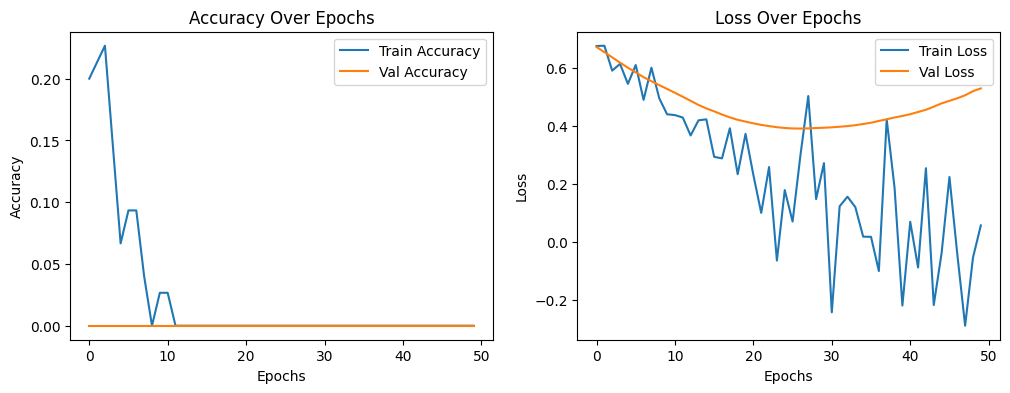

In [41]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()


In [37]:
l=[0]
l+=acc_train_list
l2=[0]
l2+=acc_val_list

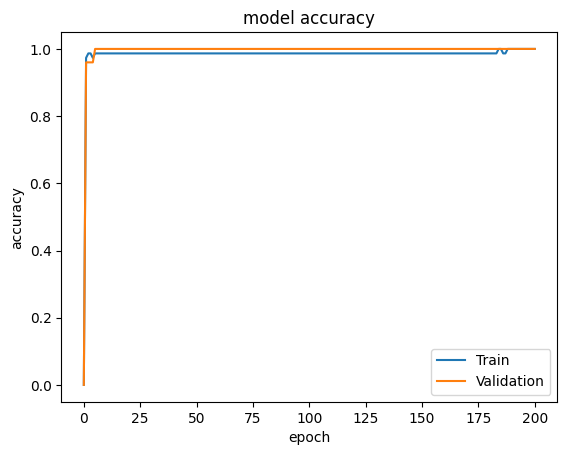

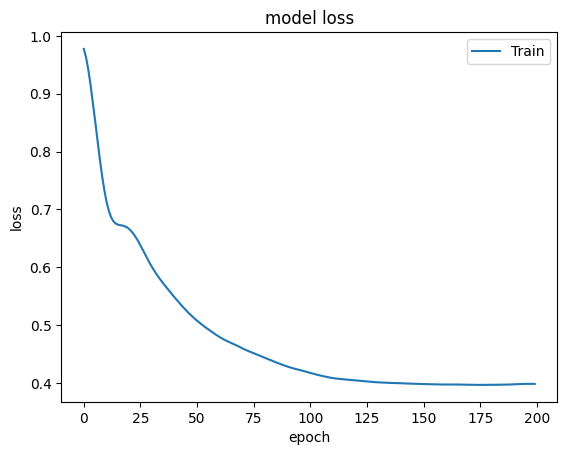

In [38]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(l[:1000])
plt.plot(l2[:1000])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()
# summarize history for loss
plt.plot(cost_list)
#plt.plot(acc_val_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()